$$ p_g\left(X_g\right)=\Phi\left(\frac{\gamma_g-w_g X_g}{\sqrt{1-w_g^2}}\right) $$

$$ p_g\left(X_g\right)=\Phi\left(aX_g+b\right) $$

$$ a = -\frac{w_g}{\sqrt{1-w_g^2}} $$

$$ b = \frac{\gamma_g}{\sqrt{1-w_g^2}} $$

The expressions of w and gamma as functions of a and b are:
$$ w_g = -\frac{a}{\sqrt{a^2 + 1}} $$
$$ \gamma_g = b \cdot \sqrt{1 - w_g^2} $$


In [1]:
def w_calc_func(a, b):
    return -a/ np.sqrt(a**2 + 1)

def gamma_calc_func(a, b):
    return b * np.sqrt(1 - w_calc_func(a, b)**2)

def a_calc_func(w, gamma):
    return - w / np.sqrt(1 - w**2)

def b_calc_func(w, gamma):
    return gamma / np.sqrt(1 - w**2)

In [2]:
import numpy as np
w = np.array([0.1])
gamma = np.array([-2, -1.7, -1.6])

a = a_calc_func(w, gamma)
b = b_calc_func(w, gamma)

a, b

(array([-0.10050378]), array([-2.01007563, -1.70856429, -1.6080605 ]))

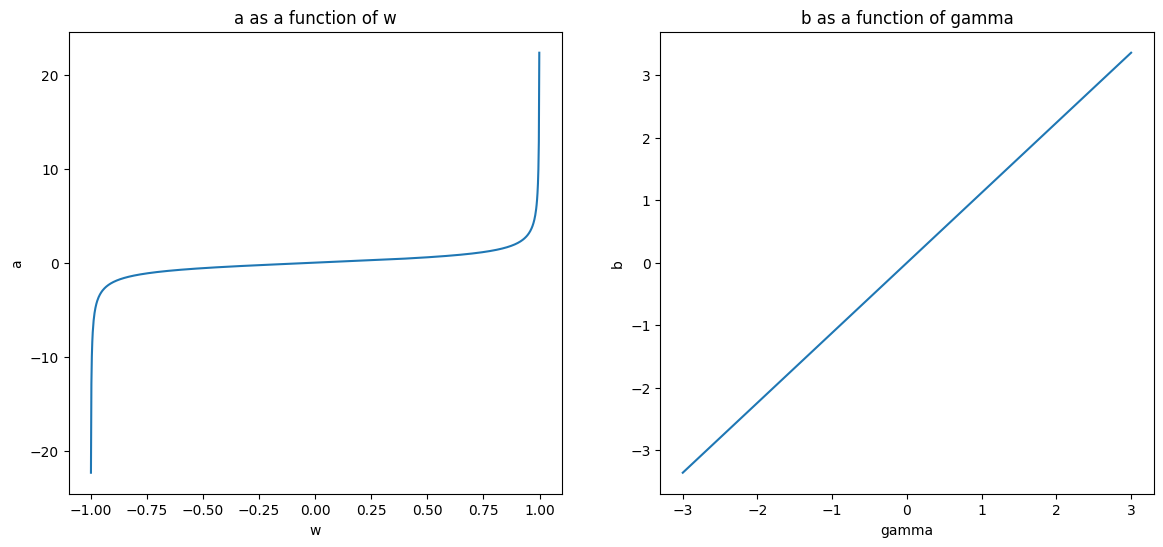

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Plot b value as a function of w if w is between -1 and 1
w = np.linspace(-0.999, 0.999, 1000)
a = w / np.sqrt(1 - w**2)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(w, a)
plt.xlabel("w")
plt.ylabel("a")
plt.title("a as a function of w")

# Plot a value as a function of gamma
gamma = np.linspace(-3, 3, 1000)
w = 0.45
b = gamma / np.sqrt(1 - w**2)

plt.subplot(1, 2, 2)
plt.plot(gamma, b)
plt.xlabel("gamma")
plt.ylabel("b")
plt.title("b as a function of gamma")

plt.show()

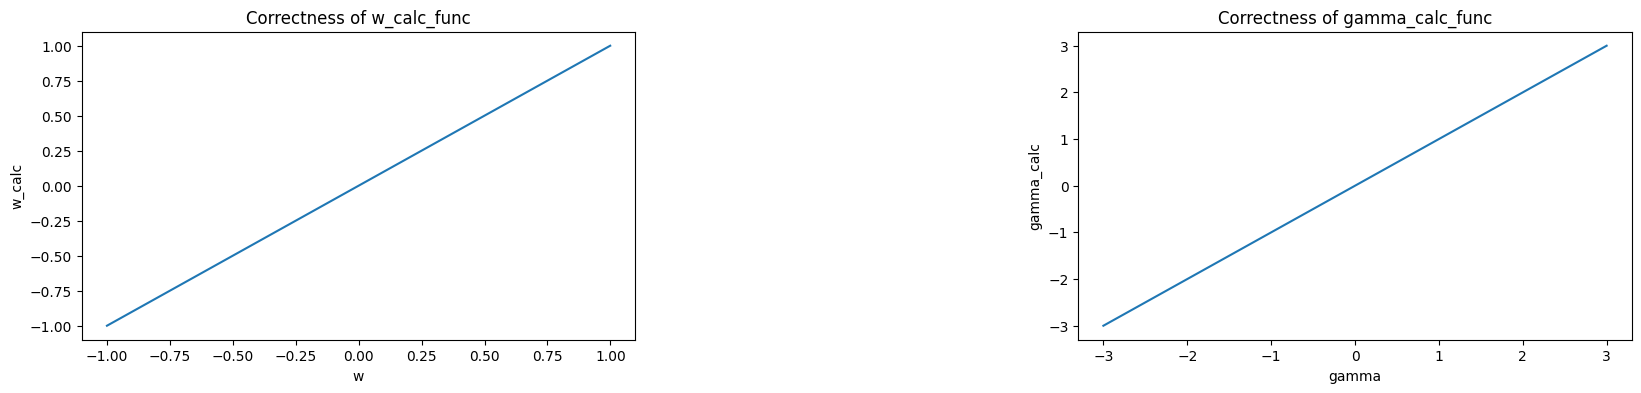

In [4]:
# Check correctness of the w_calc_func
w = np.linspace(-0.999, 0.999, 1000)
a = a_calc_func(w, 0)
w_calculated = w_calc_func(a, 0)

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(w, w_calculated)
plt.xlabel("w")
plt.ylabel("w_calc")
plt.title("Correctness of w_calc_func")

# Check correctness of the gamma_calc_func
gamma = np.linspace(-3, 3, 1000)
a = a_calc_func(0.4, gamma)
b = b_calc_func(0.4, gamma)
gamma_calculated = gamma_calc_func(a, b)

plt.subplot(1, 2, 2)
plt.plot(gamma, gamma_calculated)
plt.xlabel("gamma")
plt.ylabel("gamma_calc")
plt.title("Correctness of gamma_calc_func")

plt.subplots_adjust(wspace=0.8)
plt.show()

In [5]:
import numpy as np
from scipy.stats import norm

# Standard normal distribution cdf
phi = norm.cdf

gamma_example = -1.65
w_example = 0.35
x_example = 0.1
p1 = phi((gamma_example - w_example * x_example) / np.sqrt(1 - w_example**2))

In [6]:
a_example = a_calc_func(w_example, gamma_example)
b_example = b_calc_func(w_example, gamma_example)

p2 = phi(a_example * x_example + b_example)

In [7]:
p1, p2

(0.03602730370443671, 0.03602730370443671)

### If we switch the variables $w$ and $\gamma$ to $a$ and $b$ respectively, and then switch back to $w$ and $\gamma$, we get back the original values:

In [8]:
gamma_test = - 2.1
w_test = 0.32
w_calc_func(a_calc_func(w_test, gamma_test), b_calc_func(w_test, gamma_test)), gamma_calc_func(a_calc_func(w_test, gamma_test), b_calc_func(w_test, gamma_test))

(0.32, -2.1)

# Compare parameter estimation before and after the variable change

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, binom
from scipy.optimize import minimize
from src.data_generator import generate_default_time_series
from src.sucess_probability import p_g


factor_loading_list = [0.45, 0.45, 0.45]
pd_list = [0.012, 0.010, 0.0087]
gamma_list = norm.ppf(pd_list)
num_of_obligors_list = [1000, 1500, 900]

# Make a pandas dataframe with Grade, Factor Loading, PD, Gamma, Num of Obligors
df = pd.DataFrame({'Grade': ['A', 'B', 'C'], 'Factor Loading': factor_loading_list, 'PD': pd_list, 'Gamma': gamma_list, 'Num of Obligors': num_of_obligors_list})
df

,Grade,Factor Loading,PD,Gamma,Num of Obligors
0,A,0.45,0.0120,-2.257129,1000
1,B,0.45,0.0100,-2.326348,1500
2,C,0.45,0.0087,-2.378145,900


In [10]:
from src.ML_estimation import log_likehood_variable_changed_fast

def mle_variable_changed(
        default_table, num_of_obligors_table, factor_loading_init, gamma_list_init):

    a_init = np.array(a_calc_func(np.array(factor_loading_init), np.array(gamma_list_init)))
    b_init = np.array(b_calc_func(np.array(factor_loading_init), np.array(gamma_list_init)))

    initial_guess = np.concatenate((a_init, b_init))

    num_of_a = len(a_init)
    bounds = [(-10, 10)] * len(initial_guess)


    objective_function = lambda params: -log_likehood_variable_changed_fast(
        default_table, num_of_obligors_table, p_g, norm.pdf, params[:num_of_a], params[num_of_a:len(initial_guess)]
    )

    result = minimize(objective_function,
                      initial_guess,
                      method="Nelder-Mead",
                      bounds=bounds,
                      options={
                          'disp': False})

    factor_loading_result = np.array(w_calc_func(np.array(result.x[:num_of_a]), np.array(result.x[num_of_a:])))
    gamma_result = np.array(gamma_calc_func(np.array(result.x[:num_of_a]), np.array(result.x[num_of_a:])))

    return factor_loading_result, gamma_result, result

In [11]:
from scipy.integrate import cumtrapz

def calculate_likelihood(d_g_arr, n_g_arr, p_g, w_g_arr, gamma_g_arr):
    # Generate a range of values for y from 0 to 1
    y_values = np.linspace(0, 1, num=1000)

    # Calculate the integrand at each value of y
    integrand_values = np.prod(binom.pmf(d_g_arr, n_g_arr, p_g(norm.ppf(y_values), w_g_arr, gamma_g_arr)), axis=1)

    # Integrate the integrand using cumtrapz
    result = cumtrapz(integrand_values, y_values)[-1]

    return result

def log_likehood_multivariable(d_g_array, n_g_array, p_g, w, gamma):
    return sum(np.log(calculate_likelihood(d_g_list, n_g_list, p_g, w, gamma)) for d_g_list, n_g_list in zip(d_g_array, n_g_array))

def mle_original(default_table, num_of_obligors_table, factor_loading_init, gamma_list_init, fixed_w=False):
    initial_guess = gamma_list_init + factor_loading_init

    num_of_gamma = len(gamma_list_init)
    num_of_factor_loading = len(factor_loading_init)
    bounds = num_of_gamma * [(-5, 5)] + num_of_factor_loading * [(-1, 1)]
    # Optimization
    objective_function = lambda params: -log_likehood_multivariable(
        default_table, num_of_obligors_table, p_g, params[num_of_gamma:num_of_gamma+num_of_factor_loading], params[0:num_of_gamma]
    )

    result = minimize(objective_function,
                      initial_guess,
                      method="Nelder-Mead",
                      bounds=bounds,
                      options={
                          'disp': False})
    
    gamma_result = result.x[:num_of_gamma]
    factor_loading_result = result.x[num_of_gamma:]
    
    return factor_loading_result, gamma_result, result

In [12]:
years = 80
defaults_df = generate_default_time_series(factor_loading_list, num_of_obligors_list, gamma_list, years)
num_of_obligors_df = np.array([num_of_obligors_list] * len(defaults_df))

In [13]:
start_time = time.time()
factor_loading_variable_changed, gamma_variable_changed, result_variable_changed = mle_variable_changed(defaults_df.values, num_of_obligors_df, factor_loading_list, gamma_list)
end_time = time.time()
time_variable_changed = end_time - start_time

In [14]:
start_time = time.time()
factor_loading_before, gamma_before, result_before = mle_original(defaults_df.values, num_of_obligors_df, factor_loading_list, list(gamma_list))
end_time = time.time()
time_simple = end_time - start_time

C:\Users\kissp\AppData\Local\Temp\ipykernel_20500\1107916049.py:11: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  result = cumtrapz(integrand_values, y_values)[-1]


In [15]:
# Save the results to a dataframe
# Columns: success, fun, nit, nfev, running_time, w1, w2, w3, gamma1, gamma2, gamma3
results_df = pd.DataFrame({
    'success': [result_variable_changed.success, result_before.success],
    'fun': [result_variable_changed.fun, result_before.fun],
    'nit': [result_variable_changed.nit, result_before.nit],
    'nfev': [result_variable_changed.nfev, result_before.nfev],
    'running_time': [time_variable_changed, time_simple],
    'w1': [factor_loading_variable_changed[0], factor_loading_before[0]],
    'w2': [factor_loading_variable_changed[1], factor_loading_before[1]],
    'w3': [factor_loading_variable_changed[2], factor_loading_before[2]],
    'gamma1': [gamma_variable_changed[0], gamma_before[0]],
    'gamma2': [gamma_variable_changed[1], gamma_before[1]],
    'gamma3': [gamma_variable_changed[2], gamma_before[2]]
})
results_df

,success,fun,nit,nfev,running_time,w1,w2,w3,gamma1,gamma2,gamma3
0,True,620.503372,197,313,39.753188,0.369408,0.367222,0.351025,-2.389922,-2.447841,-2.496310
1,True,620.503373,196,309,46.817003,0.369363,0.367178,0.351020,-2.389975,-2.447882,-2.496317
